In [1]:
import sys, os

import random
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nilmtk

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import adinilm.functions as F
from adinilm.enumerations import *
from adinilm.objs import DatasetProfile, ProfileHandler, NormalizationHandler
from adinilm.utils import paths_manager as pathsman
from adinilm.io import NilmtkSubsectionExtractor


In [3]:
## Variable declaration for dataset
UKDALE_BUILDING = 1
UKDALE_START_TIME = "2015-01-01"
# END_TIME = "2015-01-15"
UKDALE_END_TIME = "2015-03-31"

FRIDGE_FREEZER = "fridge"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [4]:
ext = NilmtkSubsectionExtractor(dataset_path=pathsman.UKDALE_H5_PATH,
                                params={"start_time" : UKDALE_START_TIME,
                                        "end_time" : UKDALE_END_TIME,
                                        "building" : UKDALE_BUILDING,
                                        "appliances" : applist,
                                        "sample_period" : 1,
                                        "resample" : True,})

c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is shorter than the meter's sample_period ({})".format(
c:\users\mtinaco\dev\solutions\cos-algo-nilm\nilmtk\nilmtk\elecmeter.py:431: UserWarning: The provided sample_period (1) is shorter than the meter's sample_period (6)
  warn("The provided sample_period ({}) is s

In [5]:
ext.df.head()

,power_series,on_power_threshold
fridge,2015-01-01 00:00:04+00:00 0.0 2015-01-01 00...,50.0
washer dryer,2015-01-01 00:00:01+00:00 0.0 2015-01-01 00...,20.0
kettle,2015-01-01 00:00:04+00:00 1.0 2015-01-01 00...,10.0
dish washer,2015-01-01 00:00:05+00:00 1.0 2015-01-01 00...,10.0
microwave,2015-01-01 00:00:02+00:00 1.0 2015-01-01 00...,200.0


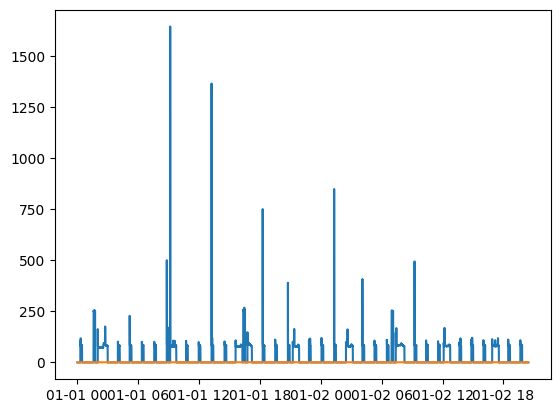

In [11]:
plt.plot(ext.df.loc[FRIDGE_FREEZER, "power_series"].iloc[:160000])
plt.plot(ext.df.loc[MICROWAVE, "power_series"].iloc[:160000])